#### In this notebook Multilinear regression model will be use to predict diameter, absorbance, and PL output.
* Optimization will be run to find the optimized estimator number 
* The skill of the model will be reported as an error in those predictions: 
    * MSE
    * R2

In [2]:
# Pandas library for the pandas dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Note - you will need version 0.24.1 of scikit-learn to load this library (SequentialFeatureSelector)
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Import numpy 
import numpy as np

# Import plotting libraries
import matplotlib 
from matplotlib import pyplot as plt

# Import statistic model library
import statsmodels.api as sm

In [3]:
# Loads the Augmented Dataset with no None Values
data = pd.read_csv('../../../Datasets/augmented_data.csv')
data

,Unnamed: 0,Unnamed: 0.1,Growth Temp (Celsius),Metal_mmol (mmol),Chalcogen_mmol (mmol),CA_mmol (mmol),Amines_mmol (mmol),Phosphines_mmol (mmol),S_I_amount (g),S_II_amount (g),...,x4_liquid parafin,x4_octadecene,x4_phenyl ether,x4_trioctylphosphine oxide,x5_None,x5_phosphinic acid,x5_trioctylphosphine oxide,Diameter_nm,Absorbance max (nm),PL max (nm)
0,0,0,1.105103,-0.437486,-0.243779,-0.525437,-0.416112,-0.165455,-0.123360,-0.302087,...,0,1,0,0,1,0,0,3.41,566.0,575.000000
1,1,1,-0.062540,-0.472027,-0.436361,-0.305510,-0.498129,-0.375671,-0.241193,-0.302087,...,0,1,0,0,1,0,0,2.50,474.0,617.000000
2,2,2,0.326674,-0.472027,-0.587674,-0.525437,-0.498129,-0.451959,-0.527427,-0.302087,...,0,1,0,0,1,0,0,1.99,450.4,497.000000
3,3,3,0.326674,-0.472027,-0.587674,-0.525437,-0.498129,-0.445602,-0.527427,-0.302087,...,0,1,0,0,1,0,0,2.13,471.6,510.000000
4,4,4,0.326674,-0.472027,-0.587674,-0.525437,-0.498129,-0.445602,-0.527427,-0.302087,...,0,1,0,0,1,0,0,2.27,486.0,517.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,229,229,0.482360,-0.465119,-0.500554,-0.386536,-0.498129,-0.370585,-0.439276,5.981667,...,0,1,0,0,0,0,1,1.70,450.0,537.714286
230,230,230,0.482360,-0.465119,-0.500554,-0.386536,-0.498129,-0.370585,-0.439276,5.981667,...,0,1,0,0,0,0,1,2.50,530.0,569.785714
231,231,231,0.482360,-0.465119,-0.500554,-0.386536,-0.498129,-0.370585,-0.439276,5.981667,...,0,1,0,0,0,0,1,3.50,585.0,589.714286
232,232,232,0.482360,-0.465119,-0.500554,-0.386536,-0.498129,-0.370585,-0.439276,5.981667,...,0,1,0,0,0,0,1,3.70,590.0,589.714286


We will be looking at Multilinear Regression and its capabilities in predicting one of the outputs individually. 

In [3]:
# Defines the input and output for the 3 models
input_col = ['Growth Temp (Celsius)', 'Metal_mmol (mmol)', 'Chalcogen_mmol (mmol)',
             'Amines_mmol (mmol)', 'CA_mmol (mmol)', 'Phosphines_mmol (mmol)', 
             'S_I_amount (g)', 'S_II_amount (g)', 'Time_min (min)', 
             'x0_cadmium acetate', 'x0_cadmium acetate dihydrate', 
             'x0_cadmium acetate dihydrate', 'x0_cadmium oxide', 
             'x0_cadmium stearate', 'x0_dimethylcadmium', 'x1_None', 
             'x1_benzoic acid', 'x1_dodecylphosphonic acid', 
             'x1_ethylphosphonic acid', 'x1_lauric acid', 
             'x1_myrstic acid', 'x1_oleic acid', 'x1_stearic acid',
             'x2_2-6-dimethylpyridine', 'x2_None', 'x2_aniline', 
             'x2_benzylamine', 'x2_dioctylamine/hexadecylamine',
             'x2_dodecylamine', 'x2_heptylamine', 'x2_hexadecylamine', 
             'x2_octadecylamine', 'x2_octylamine', 'x2_oleylamine', 
             'x2_pyridine', 'x2_trioctylamine', 'x3_None', 'x3_diphenylphosphine', 
             'x3_tributylphosphine', 'x3_trioctylphosphine', 
             'x3_triphenylphosphine', 'x4_None', 'x4_liquid parafin', 
             'x4_octadecene', 'x4_phenyl ether', 'x4_trioctylphosphine oxide', 
             'x5_None', 'x5_phosphinic acid', 'x5_trioctylphosphine oxide']

output_col_d = ['Diameter_nm']
output_col_ab = ['Absorbance max (nm)']
output_col_pl = ['PL max (nm)']

X_total = data[input_col]
Y_total_d = data[output_col_d]
Y_total_ab = data[output_col_ab]
Y_total_pl = data[output_col_pl]

In [8]:
# Defines 3 training and testing data sets by taking 20% of the original sample as the testing data set
X_train, X_test, y_train_d, y_test_d = train_test_split(X_total, Y_total_d, test_size=0.2, random_state=42, shuffle=True)
X_train, X_test, y_train_ab, y_test_ab = train_test_split(X_total, Y_total_ab, test_size=0.2, random_state=42, shuffle=True)
X_train, X_test, y_train_pl, y_test_pl = train_test_split(X_total, Y_total_pl, test_size=0.2, random_state=42, shuffle=True)

In [9]:
# Creates the 3 linear regression objects for each model
reg_d = linear_model.LinearRegression()
reg_ab = linear_model.LinearRegression()
reg_pl = linear_model.LinearRegression()

# Use each model to fit the training data
reg_d.fit(X_train, y_train_d)
reg_ab.fit(X_train, y_train_ab)
reg_pl.fit(X_train, y_train_pl)

# Use each model to predict the output for the testing dataset
y_predict_d = reg_d.predict(X_test)
y_predict_ab = reg_ab.predict(X_test)
y_predict_pl = reg_pl.predict(X_test)

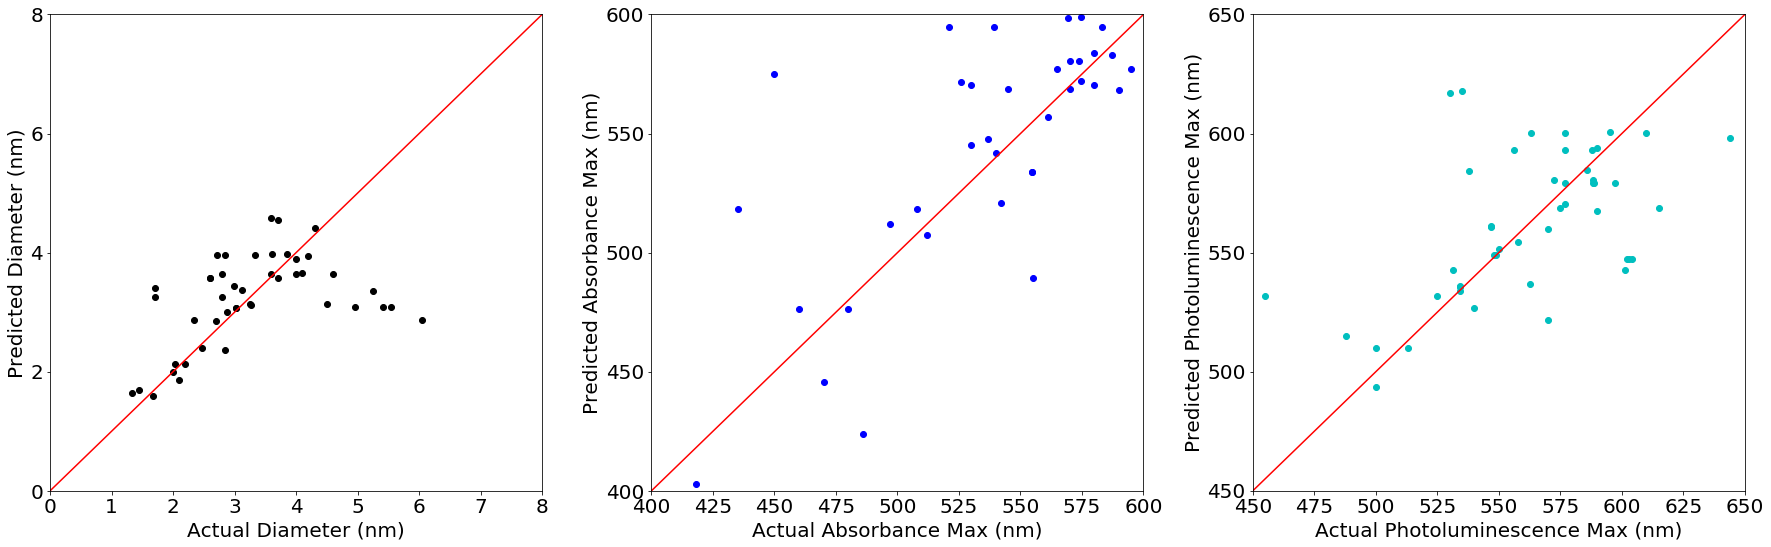

In [10]:
# Plot graphs of the predicted vs actual for each case
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(figsize = (25,8), nrows = 1, ncols =3)

axes[0].scatter(y_test_d, y_predict_d, color='k')
axes[0].plot([0, 1],[0, 1], transform=axes[0].transAxes, color = 'r')
axes[0].set_xlim(0,8)
axes[0].set_ylim(0,8)
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].set_xlabel('Actual Diameter (nm)')
axes[0].set_ylabel('Predicted Diameter (nm)')

axes[1].scatter(y_test_ab, y_predict_ab, color='b')
axes[1].plot([0, 1],[0, 1], transform=axes[1].transAxes, color = 'r')
axes[1].set_xlim(400,600)
axes[1].set_ylim(400,600)
axes[1].set_yticks([400, 450, 500, 550, 600])
axes[1].set_xlabel('Actual Absorbance Max (nm)')
axes[1].set_ylabel('Predicted Absorbance Max (nm)')

axes[2].scatter(y_test_pl, y_predict_pl, color='c')
axes[2].plot([0,1],[0,1], transform=axes[2].transAxes, color = 'r')
axes[2].set_xlim(450, 650)
axes[2].set_ylim(450, 650)
axes[2].set_yticks([450, 500, 550, 600, 650])
axes[2].set_xlabel('Actual Photoluminescence Max (nm)')
axes[2].set_ylabel('Predicted Photoluminescence Max (nm)')

plt.tight_layout()

In [18]:
# Calculate the mean squared error 
print('MSE for diameter prediction:', round(mean_squared_error(y_test_d, y_predict_d), 2))
print('MSE squared error for absorbance max prediction:', round(mean_squared_error(y_test_ab, y_predict_ab), 2))
print('MSE squared error for PL max prediction:', round(mean_squared_error(y_test_pl, y_predict_pl), 2))

print('\n')

# Calculate the R^2 value 
print('R squared for diameter prediction:', round(r2_score(y_test_d, y_predict_d), 2))
print('R squared error for absorbance max prediction:', round(r2_score(y_test_ab, y_predict_ab), 2))
print('R squared error for PL max prediction:', round(r2_score(y_test_pl, y_predict_pl), 2))

print('\n')

#Calculate the MAE 
print('MAE for diameter prediction:', round(mean_absolute_error(y_test_d, y_predict_d), 2))

MSE for diameter prediction: 2.01
MSE squared error for absorbance max prediction: 2439.1
MSE squared error for PL max prediction: 1044.73


R squared for diameter prediction: 0.17
R squared error for absorbance max prediction: 0.43
R squared error for PL max prediction: 0.21


MAE for diameter prediction: 0.86


### F-statistic Analysis

Here, we use the F-statistic to see the validity of our hypothesis that our output depends on at least one of the input features. Intuitively, we know that this should be true because the CdSe dots were synthesized as a result of the experimental inputs which we used as our input data. So at least we know that it depends on at least one of the input variables, which confirms the validity of the aforementioned hypothesis. 

Below, let us calculate the F-statistic for the 3 different models.

In [12]:
mreg_1 = sm.OLS(y_train_d, X_train).fit()
mreg_1.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Diameter_nm   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     2.678
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           1.13e-05
Time:                        22:35:32   Log-Likelihood:                -250.74
No. Observations:                 187   AIC:                             581.5
Df Residuals:                     147   BIC:                             710.7
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|       [0.05       0.95]
--------------------------------------------------------------------------------------------------
Growth Temp (Celsius)              0.5836      0.349      1.673      0.096       0.006       1.161
Metal_mmol (mmol)                  0.3865      1.059      0.365      0.716      -1.367       2.140
Chalcogen_mmol (mmol)             -0.9763      0.905     -1.079      0.282      -2.474       0.521
Amines_mmol (mmol)                -0.2156      0.238     -0.904      0.367      -0.610       0.179
CA_mmol (mmol)                    -0.2979      0.615     -0.484      0.629      -1.316       0.720
Phosphines_mmol (mmol)             0.3826      0.630      0.607      0.545      -0.660       1.425
S_I_amount (g)                     0.1373      0.329      0.417      0.677      -0.408       0.683
S_II_amount (g)                   -0.0395      0.108     -0.365      0.715      -0.219       0.140
Time_min (min)                     0.0324      0.132      0.245      0.807      -0.186       0.251
x0_cadmium acetate                 0.8802      0.995      0.884      0.378      -0.768       2.528
x0_cadmium acetate dihydrate       0.3477      0.359      0.968      0.335      -0.247       0.943
x0_cadmium acetate dihydrate       0.3477      0.359      0.968      0.335      -0.247       0.943
x0_cadmium oxide                   0.3426      0.772      0.444      0.658      -0.934       1.620
x0_cadmium stearate                0.4767      1.182      0.403      0.687      -1.479       2.433
x0_dimethylcadmium                 1.8737      1.245      1.504      0.135      -0.188       3.935
x1_None                            0.1876      1.337      0.140      0.889      -2.025       2.400
x1_benzoic acid                   -0.4305      3.434     -0.125      0.900      -6.115       5.254
x1_dodecylphosphonic acid          0.9698      4.913      0.197      0.844      -7.162       9.102
x1_ethylphosphonic acid            0.6859      1.204      0.569      0.570      -1.308       2.680
x1_lauric acid                     0.5990      1.202      0.498      0.619      -1.391       2.589
x1_myrstic acid                    0.4680      0.847      0.553      0.581      -0.934       1.870
x1_oleic acid                      0.8823      0.719      1.228      0.221      -0.307       2.072
x1_stearic acid                    0.5589      0.816      0.685      0.494      -0.791       1.909
x2_2-6-dimethylpyridine         1.907e-15   2.77e-15      0.688      0.492   -2.68e-15    6.49e-15
x2_None                           -0.1337      0.598     -0.223      0.823      -1.124       0.856
x2_aniline                      -5.71e-15   1.11e-14     -0.515      0.607   -2.41e-14    1.26e-14
x2_benzylamine                    -0.2150      1.262     -0.170      0.865      -2.303       1.873
x2_dioctylamine/hexadecylamine     3.1661      3.329      0.951      0.343      -2.345       8.677
x2_dodecylamin

In [13]:
mreg_2 = sm.OLS(y_train_ab, X_train).fit()
mreg_2.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Absorbance max (nm)   R-squared:                       0.640
Model:                             OLS   Adj. R-squared:                  0.545
Method:                  Least Squares   F-statistic:                     6.705
Date:                 Wed, 10 Mar 2021   Prob (F-statistic):           8.38e-18
Time:                         22:35:32   Log-Likelihood:                -951.33
No. Observations:                  187   AIC:                             1983.
Df Residuals:                      147   BIC:                             2112.
Df Model:                           39                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|       [0.05       0.95]
--------------------------------------------------------------------------------------------------
Growth Temp (Celsius)             66.3023     14.779      4.486      0.000      41.839      90.765
Metal_mmol (mmol)                 62.2733     44.884      1.387      0.167     -12.023     136.569
Chalcogen_mmol (mmol)            -17.4167     38.340     -0.454      0.650     -80.881      46.047
Amines_mmol (mmol)                 4.8623     10.100      0.481      0.631     -11.857      21.581
CA_mmol (mmol)                   -17.7405     26.067     -0.681      0.497     -60.890      25.409
Phosphines_mmol (mmol)           -37.3643     26.696     -1.400      0.164     -81.553       6.825
S_I_amount (g)                    -5.2678     13.958     -0.377      0.706     -28.373      17.837
S_II_amount (g)                    1.0879      4.588      0.237      0.813      -6.506       8.682
Time_min (min)                     2.6209      5.602      0.468      0.641      -6.652      11.894
x0_cadmium acetate               108.3428     42.177      2.569      0.011      38.529     178.157
x0_cadmium acetate dihydrate      64.6046     15.227      4.243      0.000      39.400      89.809
x0_cadmium acetate dihydrate      64.6046     15.227      4.243      0.000      39.400      89.809
x0_cadmium oxide                 106.4629     32.690      3.257      0.001      52.351     160.574
x0_cadmium stearate               94.9226     50.072      1.896      0.060      12.039     177.807
x0_dimethylcadmium                73.3584     52.773      1.390      0.167     -13.997     160.713
x1_None                           68.0552     56.630      1.202      0.231     -25.683     161.794
x1_benzoic acid                   25.8385    145.500      0.178      0.859    -215.005     266.682
x1_dodecylphosphonic acid          1.1722    208.157      0.006      0.996    -343.387     345.731
x1_ethylphosphonic acid           79.7504     51.034      1.563      0.120      -4.725     164.226
x1_lauric acid                    90.3397     50.930      1.774      0.078       6.036     174.644
x1_myrstic acid                   24.1705     35.881      0.674      0.502     -35.223      83.564
x1_oleic acid                     96.7121     30.446      3.177      0.002      46.315     147.109
x1_stearic acid                   61.6526     34.564      1.784      0.077       4.440     118.865
x2_2-6-dimethylpyridine         8.036e-14   1.17e-13      0.684      0.495   -1.14e-13    2.75e-13
x2_None                           47.7182     25.343      1.883      0.062       5.768      89.668
x2_aniline                     -1.425e-13    4.7e-13     -0.303      0.762    -9.2e-13    6.35e-13
x2_benzylamine                    26.2443     53.456      0.491      0.624     -62.241     114.730
x2_dioctylamine/hexadecylamine    74.6184    141.068      0.529      0.598    -158.890     308.126
x2_

In [14]:
mreg_3 = sm.OLS(y_train_pl, X_train).fit()
mreg_3.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PL max (nm)   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     5.009
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           4.59e-13
Time:                        22:35:33   Log-Likelihood:                -880.14
No. Observations:                 187   AIC:                             1840.
Df Residuals:                     147   BIC:                             1970.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|       [0.05       0.95]
--------------------------------------------------------------------------------------------------
Growth Temp (Celsius)             35.4141     10.099      3.507      0.001      18.697      52.132
Metal_mmol (mmol)                 37.6011     30.673      1.226      0.222     -13.171      88.373
Chalcogen_mmol (mmol)            -17.1786     26.201     -0.656      0.513     -60.548      26.191
Amines_mmol (mmol)                 6.2675      6.902      0.908      0.365      -5.158      17.693
CA_mmol (mmol)                   -35.8300     17.814     -2.011      0.046     -65.317      -6.343
Phosphines_mmol (mmol)           -34.9687     18.243     -1.917      0.057     -65.166      -4.771
S_I_amount (g)                     6.7414      9.539      0.707      0.481      -9.048      22.531
S_II_amount (g)                    0.8483      3.135      0.271      0.787      -4.341       6.038
Time_min (min)                     2.8356      3.828      0.741      0.460      -3.501       9.172
x0_cadmium acetate               142.6424     28.822      4.949      0.000      94.933     190.352
x0_cadmium acetate dihydrate      62.1512     10.405      5.973      0.000      44.927      79.375
x0_cadmium acetate dihydrate      62.1512     10.405      5.973      0.000      44.927      79.375
x0_cadmium oxide                 123.3211     22.340      5.520      0.000      86.343     160.300
x0_cadmium stearate               99.4373     34.218      2.906      0.004      42.796     156.078
x0_dimethylcadmium               117.2409     36.064      3.251      0.001      57.545     176.937
x1_None                           50.0273     38.699      1.293      0.198     -14.031     114.086
x1_benzoic acid                  -51.9104     99.431     -0.522      0.602    -216.497     112.676
x1_dodecylphosphonic acid        185.2385    142.250      1.302      0.195     -50.225     420.702
x1_ethylphosphonic acid           76.9429     34.875      2.206      0.029      19.214     134.671
x1_lauric acid                   123.1134     34.804      3.537      0.001      65.502     180.725
x1_myrstic acid                   16.1676     24.520      0.659      0.511     -24.421      56.756
x1_oleic acid                     80.4365     20.806      3.866      0.000      45.996     114.877
x1_stearic acid                   64.7771     23.620      2.742      0.007      25.679     103.875
x2_2-6-dimethylpyridine          1.47e-13   8.02e-14      1.832      0.069    1.42e-14     2.8e-13
x2_None                           32.7601     17.319      1.892      0.061       4.092      61.428
x2_aniline                     -4.913e-13   3.21e-13     -1.530      0.128   -1.02e-12    4.03e-14
x2_benzylamine                    -2.5840     36.531     -0.071      0.944     -63.053      57.885
x2_dioctylamine/hexadecylamine   171.2741     96.403      1.777      0.078      11.700     330.848
x2_dodecylamin

### Backward Stepwise Selection

In [15]:
# Backward Feature selector for Diameter Prediction
sfs_backward_d = SequentialFeatureSelector(linear_model.LinearRegression(),
                                        n_features_to_select=5,
                                        direction='backward').fit(X_total, Y_total_d)

selected = sfs_backward_d.get_support(indices=True)
print("Selected 5 input features using Backward Stepwise Selection for diameter prediction: \n", np.array(input_col)[selected])

Selected 5 input features using Backward Stepwise Selection for diameter prediction: 
 ['Growth Temp (Celsius)' 'x1_oleic acid' 'x2_hexadecylamine'
 'x3_trioctylphosphine' 'x4_octadecene']


In [16]:
# Backward Feature selector for Absorbance Max Prediction
sfs_backward_ab = SequentialFeatureSelector(linear_model.LinearRegression(),
                                        n_features_to_select=5,
                                        direction='backward').fit(X_total, Y_total_ab)

selected = sfs_backward_ab.get_support(indices=True)
print("Selected 5 input features using Backward Stepwise Selection for absorbance max prediction: \n", np.array(input_col)[selected])

Selected 5 input features using Backward Stepwise Selection for absorbance max prediction: 
 ['Growth Temp (Celsius)' 'Metal_mmol (mmol)' 'CA_mmol (mmol)'
 'x1_oleic acid' 'x1_stearic acid']


In [17]:
# Backward Feature selector for Photoluminescence Max Prediction
sfs_backward_pl = SequentialFeatureSelector(linear_model.LinearRegression(),
                                        n_features_to_select=5,
                                        direction='backward').fit(X_total, Y_total_pl)

selected = sfs_backward_pl.get_support(indices=True)
print("Selected 5 input features using Backward Stepwise Selection for photoluminescence prediction: \n", np.array(input_col)[selected])

Selected 5 input features using Backward Stepwise Selection for photoluminescence prediction: 
 ['Growth Temp (Celsius)' 'x0_cadmium oxide' 'x2_hexadecylamine'
 'x3_trioctylphosphine' 'x4_octadecene']


### Residual Plot Comparison

The point of this analysis is to get a sense of whether the response-predictor relationship is linear. To do so, we will look at a plot of the residual error vs the y_test for each model.

The first thing we have to do is create a polynomial fit for each model and compare the residual error vs y_test_(output feature) relationship of each model. 

In [15]:
# Degree of polynomial model
degree = 3

# Fitting and Predicting using a polynomial model of degree 5 for diameter of dots
model_d = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
model_d.fit(X_train, y_train_d)
y_poly_pred_d = model_d.predict(X_test)

# Fitting and Predicting using a polynomial model of degree 5 for absorbance of dots
model_ab = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
model_ab.fit(X_train, y_train_ab)
y_poly_pred_ab = model_ab.predict(X_test)

# Fitting and Predicting using a polynomial model of degree 5 for PL of dots
model_pl = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
model_pl.fit(X_train, y_train_pl)
y_poly_pred_pl = model_pl.predict(X_test)

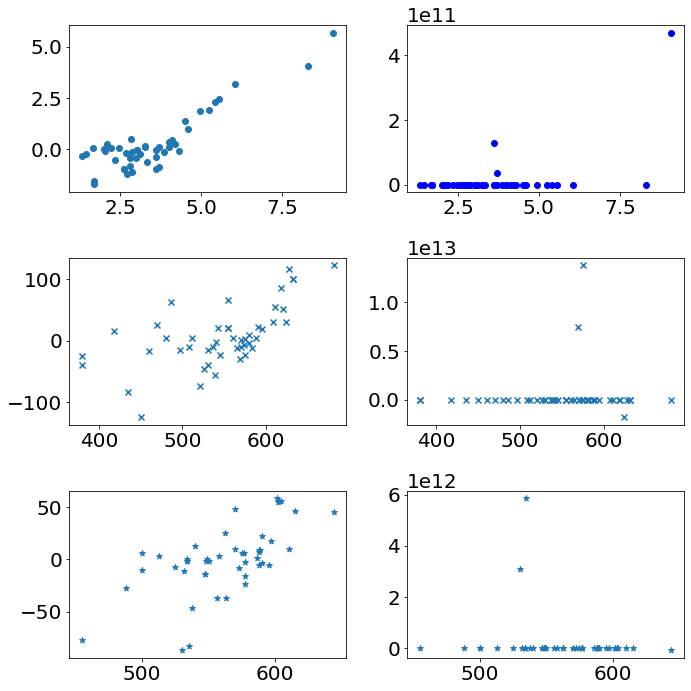

In [16]:
# Plots the residual plots
fig, axes = plt.subplots(figsize = (10,10), nrows = 3, ncols =2)

axes[0,0].scatter(y_test_d, y_test_d - y_predict_d, marker='o')
axes[0,1].scatter(y_test_d, y_test_d - y_poly_pred_d, marker='o', color='b')

axes[1,0].scatter(y_test_ab, y_test_ab - y_predict_ab, marker='x')
axes[1,1].scatter(y_test_ab, y_test_ab - y_poly_pred_ab, marker='x')

axes[2,0].scatter(y_test_pl, y_test_pl - y_predict_pl, marker='*')
axes[2,1].scatter(y_test_pl, y_test_pl - y_poly_pred_pl, marker='*')

plt.tight_layout()

### K-Cross Validation for each of the 3 linear models

In [17]:
# Sets the number of splits used in K-Cross Validation
kf = KFold(n_splits=5)

# K-Cross Validation for the 3 models
MSE_kf_d = []
MSE_kf_ab = []
MSE_kf_pl = []

for train_index, test_index in kf.split(X_total):
    # Splits the input data into testing and training sets
    X_train, X_test = X_total.iloc[train_index], X_total.iloc[test_index]
    
    # Splits the output data based on how the input data set was split
    y_train_d, y_test_d = Y_total_d.iloc[train_index], Y_total_d.iloc[test_index]
    y_train_ab, y_test_ab = Y_total_ab.iloc[train_index], Y_total_ab.iloc[test_index]
    y_train_pl, y_test_pl = Y_total_pl.iloc[train_index], Y_total_pl.iloc[test_index]
    
    # Trains the 3 different models with the training dataset
    reg_d = linear_model.LinearRegression().fit(X_train, y_train_d)
    reg_ab = linear_model.LinearRegression().fit(X_train, y_train_ab)
    reg_pl = linear_model.LinearRegression().fit(X_train, y_train_pl)
    
    # Predicts the output for the testing dataset
    y_predict_d = reg_d.predict(X_test)
    y_predict_ab = reg_ab.predict(X_test)
    y_predict_pl = reg_pl.predict(X_test)
    MSE_kf_d.append(mean_squared_error(y_test_d, y_predict_d))
    MSE_kf_ab.append(mean_squared_error(y_test_ab, y_predict_ab))
    MSE_kf_pl.append(mean_squared_error(y_test_pl, y_predict_pl))


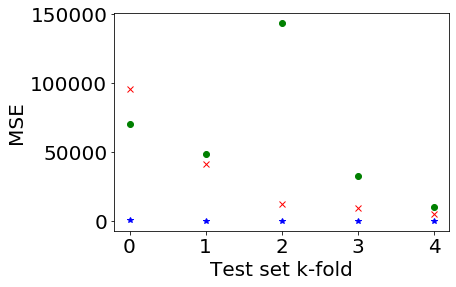

In [18]:
plt.figure()
plt.plot(MSE_kf_d,'*', color='blue', label='diameter')
plt.plot(MSE_kf_ab,'o', color='green', label='ABS max')
plt.plot(MSE_kf_pl,'x', color='red', label='PL max')
plt.xlabel('Test set k-fold')
plt.ylabel('MSE')
plt.show()

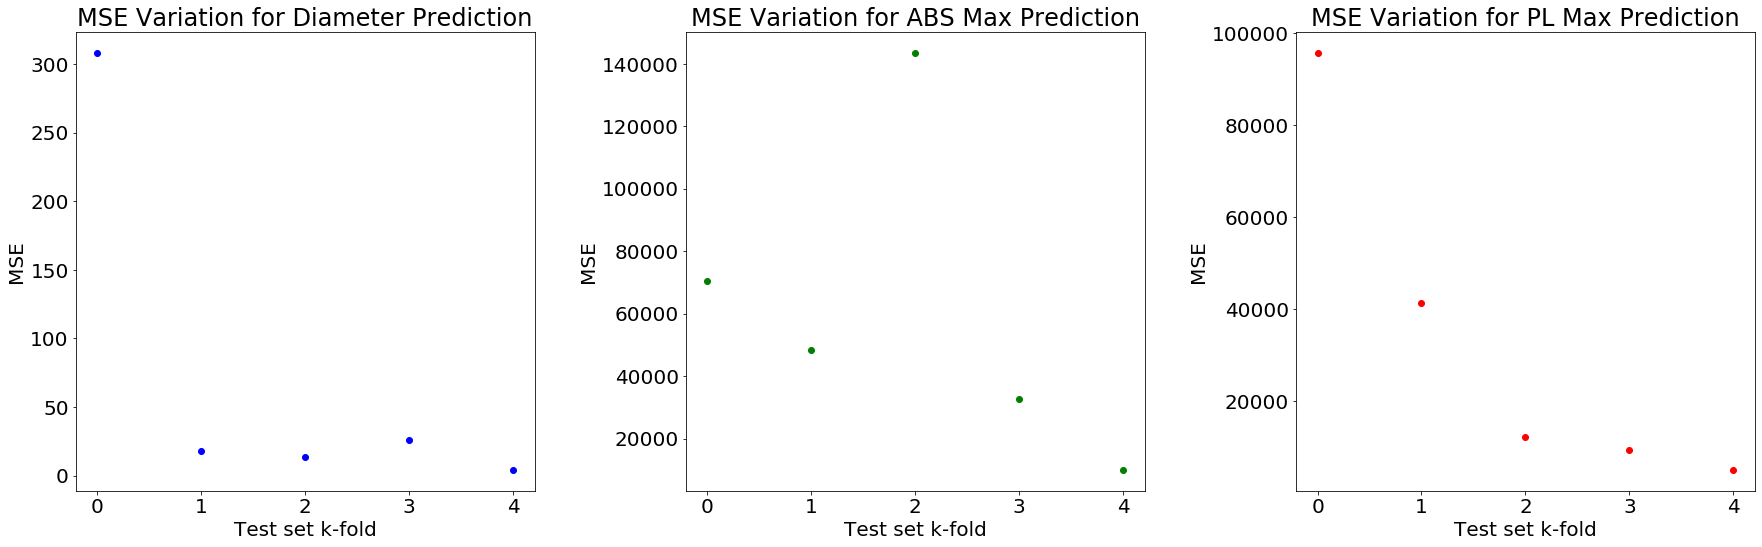

In [19]:
# Plot graphs of the predicted vs actual for each case
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(figsize = (25,8), nrows = 1, ncols =3)

axes[0].scatter([0, 1, 2, 3, 4], MSE_kf_d, color='blue', label='diameter')
axes[0].set_xlabel('Test set k-fold')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE Variation for Diameter Prediction')

axes[1].scatter([0, 1, 2, 3, 4], MSE_kf_ab, color='green', label='diameter')
axes[1].set_xlabel('Test set k-fold')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE Variation for ABS Max Prediction')

axes[2].scatter([0, 1, 2, 3, 4], MSE_kf_pl, color='red', label='diameter')
axes[2].set_xlabel('Test set k-fold')
axes[2].set_ylabel('MSE')
axes[2].set_title('MSE Variation for PL Max Prediction')

plt.tight_layout()

In [20]:
# Calculates the mean of the MSE across 5 test/train datasets
CV_mean_5fold_MSE_d = 1/5. * np.sum(MSE_kf_d)
CV_mean_5fold_MSE_ab = 1/5. * np.sum(MSE_kf_ab)
CV_mean_5fold_MSE_pl = 1/5. * np.sum(MSE_kf_pl)

print("Mean test MSE for diameter prediction using 5-fold CV ", round((CV_mean_5fold_MSE_d),2))
print("Mean test MSE for ABS Max prediction using 5-fold CV ", round((CV_mean_5fold_MSE_ab),2))
print("Mean test MSE for PL Max prediction using 5-fold CV ", round((CV_mean_5fold_MSE_pl), 2))

Mean test MSE for diameter prediction using 5-fold CV  73.93
Mean test MSE for ABS Max prediction using 5-fold CV  60975.98
Mean test MSE for PL Max prediction using 5-fold CV  32774.19
